# **Bulding a RNN multivariate model**

The basic idea is to predict the stock returns of Apple and Amazon, as has already been done in the univariate case, but also taking a look at what happens to companies competing in the same sector. Specifically, we will consider Samsung (a competitor of Apple) and the Alibaba Group (a competitor of Amazon).

In [ ]:
!pip install tensorflow --quiet
!pip install yfinance   --quiet

import math as mt
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow import keras
from seaborn import set_style
from sklearn.preprocessing import MinMaxScaler

set_style("darkgrid")

# For reproducibility
np.random.seed(24)
tf.random.set_seed(24)

In [ ]:
start_date = "2020-06-24"
end_date   = "2023-06-24"

apple_ticker  = "AAPL"
smsg_ticker   = "005930.KS" # Ticker symbol for Samsung on Korea Stock Exchange (KS)

amazon_ticker = "AMZN"
baba_ticker   = "BABA"  # Ticker symbol for Alibaba Group on NYSE

AAPL = yf.download(apple_ticker, start=start_date, end=end_date)
SMSG = yf.download(smsg_ticker, start=start_date, end=end_date)

AMZN = yf.download(amazon_ticker, start=start_date, end=end_date)
BABA = yf.download(baba_ticker, start=start_date, end=end_date)

AAPL.index = pd.to_datetime(AAPL.index)
AMZN.index = pd.to_datetime(AMZN.index)
BABA.index = pd.to_datetime(BABA.index)
SMSG.index = pd.to_datetime(SMSG.index)

In [ ]:
SMSG.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-19,71300.0,71700.0,70900.0,71200.0,71200.0,11100887
2023-06-20,70700.0,71400.0,70400.0,71400.0,71400.0,11557883
2023-06-21,70700.0,71200.0,70400.0,70500.0,70500.0,10626603
2023-06-22,70200.0,71500.0,70100.0,71300.0,71300.0,11411007
2023-06-23,72000.0,72200.0,71600.0,71600.0,71600.0,12329484


In [ ]:

BABA.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-16,94.000000,94.290001,91.519997,92.099998,92.099998,25048200
2023-06-20,89.830002,90.199997,87.320000,87.930000,87.930000,23382900
2023-06-21,87.379997,89.160004,86.620003,86.769997,86.769997,15159900
2023-06-22,86.779999,87.315002,85.320000,86.889999,86.889999,10272700
2023-06-23,85.809998,85.938004,84.370003,84.919998,84.919998,14830800


Before starting the analysis, it is necessary to understand that there exists a correlation (or anticorrelation) between the returns of a company and the chosen competitor.

In [ ]:
AAPL['AAPL Close']  = AAPL['Close']
AAPL['AAPL Volume'] = AAPL['Volume']

# SK WON to USD (08-07-2023):
WON_USD = 0.000770
SMSG['SMSG Close']  = SMSG['Close'] * WON_USD
SMSG['SMSG Volume'] = SMSG['Volume']

AAPL = AAPL.drop(['Open','High','Low','Close','Adj Close','Volume'], axis=1)
SMSG = SMSG.drop(['Open','High','Low','Close','Adj Close','Volume'], axis=1)


AMZN['AMZN Close']  = AMZN['Close']
AMZN['AMZN Volume'] = AMZN['Volume']

BABA['BABA Close']  = BABA['Close']
BABA['BABA Volume'] = BABA['Volume']

AMZN = AMZN.drop(['Open','High','Low','Close','Adj Close','Volume'], axis=1)
BABA = BABA.drop(['Open','High','Low','Close','Adj Close','Volume'], axis=1)


# Merge the two DataFrames based on 'Date' column
AAPL_SMSG = pd.merge(AAPL, SMSG, on='Date', how='inner')
AMZN_BABA = pd.merge(AMZN, BABA, on='Date', how='inner')

In [ ]:
T = 21

AAPL_returns = AAPL_SMSG['AAPL Close'] - AAPL_SMSG['AAPL Close'].shift(T)
SMSG_returns = AAPL_SMSG['SMSG Close'] - AAPL_SMSG['SMSG Close'].shift(T)

AMZN_returns = AMZN_BABA['AMZN Close'] - AMZN_BABA['AMZN Close'].shift(T)
BABA_returns = AMZN_BABA['BABA Close'] - AMZN_BABA['BABA Close'].shift(T)

AAPL_SMSG['AAPL Ret'] = AAPL_returns
AAPL_SMSG['SMSG Ret'] = SMSG_returns

AMZN_BABA['AMZN Ret'] = AMZN_returns
AMZN_BABA['BABA Ret'] = BABA_returns

AAPL_SMSG = AAPL_SMSG.iloc[T:]
AMZN_BABA = AMZN_BABA.iloc[T:]

In [ ]:
AAPL_SMSG.head()

,AAPL Close,AAPL Volume,SMSG Close,SMSG Volume,AAPL Ret,SMSG Ret
Date,,,,,,
2020-07-24,92.614998,185438800,41.734,10994535,2.599998,1.001
2020-07-27,94.809998,121214000,42.812,21054421,3.599998,2.849
2020-07-28,93.252502,103625600,45.122,48431566,4.845001,4.081
2020-07-29,95.040001,90329200,45.430,36476611,4.595001,5.082
2020-07-30,96.190002,158130000,45.430,19285354,4.990005,4.774


In [ ]:
AMZN_BABA.head()

,AMZN Close,AMZN Volume,BABA Close,BABA Volume,AMZN Ret,BABA Ret
Date,,,,,,
2020-07-24,150.445496,112648000,249.000000,17221500,13.725494,22.779999
2020-07-27,152.760498,83410000,250.860001,18966900,15.031494,28.699997
2020-07-28,150.016495,62534000,249.050003,9878700,15.373001,33.339996
2020-07-29,151.676498,59482000,252.449997,11493600,17.657501,37.429993
2020-07-30,152.593994,122566000,252.740005,7032900,14.653000,37.040009


In [ ]:
import scipy.stats as stats

# Apply Pearson correlation
correlation, p_value = stats.pearsonr(AAPL_SMSG['AAPL Ret'].values, AAPL_SMSG['SMSG Ret'].values)

print("AAPL-SMSG Pearson correlation coefficient:", correlation)
print("\tp-value:", p_value)

correlation, p_value = stats.pearsonr(AMZN_BABA['AMZN Ret'].values, AMZN_BABA['BABA Ret'].values)

print("\nAMZN-BABA Pearson correlation coefficient:", correlation)
print("\tp-value:", p_value)

AAPL-SMSG Pearson correlation coefficient: 0.4131004285453169
	p-value: 5.5670413547235606e-30

AMZN-BABA Pearson correlation coefficient: 0.25489106921438004
	p-value: 2.3839042329756787e-12


The null hypothesis used in the Pearson correlation test implemented by the `scipy.stats.pearsonr` function states that **there is no correlation between the two variables** in the population. In other words, the null hypothesis assumes that the true population correlation coefficient is zero.

If the p-value is below a chosen significance level (e.g., 0.05), the null hypothesis can be rejected in favor of the alternative hypothesis, indicating that there is a statistically significant correlation between the variables.

AAPL-SMSG:
- A coefficient of `0.4131` indicates a moderate positive correlation between AAPL and SMSG stock returns. This means that, on average, when the stock returns of Apple increase, the stock returns of Samsung tend to increase as well, and vice versa.
- In this case, the p-value is extremely small (`5.567e-30`), which is close to zero. This suggests that the observed correlation between AAPL and SMSG stock returns is highly unlikely to occur by chance.

AMZN-BABA:
- In this case, the coefficient indicates a weak positive correlation between AMZN and BABA stock returns. It suggests that there is a tendency for the stock returns of Amazon and Alibaba to move together, but the correlation is not as strong as in the AAPL-SMSG case.
- The p-value for the AMZN-BABA correlation is also very small (`2.384e-12`), indicating that the observed correlation is statistically significant.




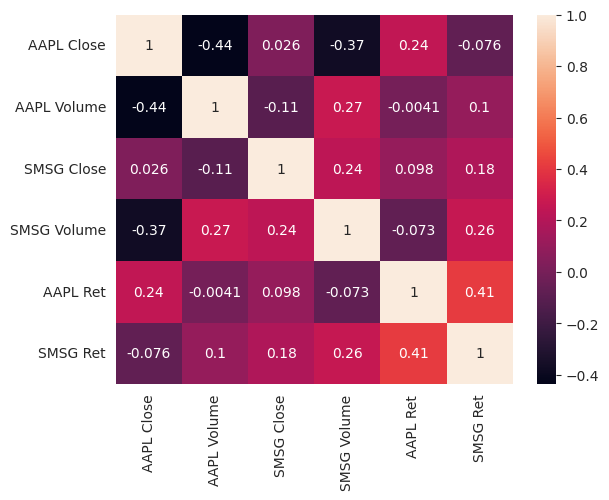

In [ ]:
import seaborn as sn
corr_matrix = AAPL_SMSG.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()


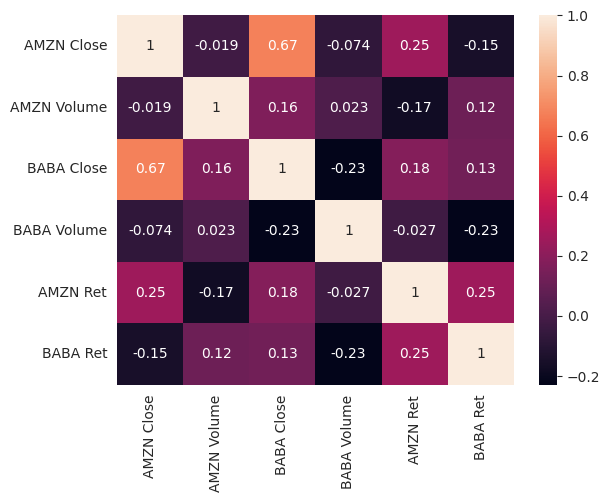

In [ ]:
corr_matrix = AMZN_BABA.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

## **Creating train, validation and test dataset**

In [ ]:

window_size = 7

AAPL_SMSG['AAPL Ret'] = AAPL_SMSG['AAPL Ret'].rolling(window=window_size).mean()
AAPL_SMSG['SMSG Ret'] = AAPL_SMSG['SMSG Ret'].rolling(window=window_size).mean()
AMZN_BABA['AMZN Ret'] = AMZN_BABA['AMZN Ret'].rolling(window=window_size).mean()
AMZN_BABA['BABA Ret'] = AMZN_BABA['BABA Ret'].rolling(window=window_size).mean()

AAPL_SMSG = AAPL_SMSG.dropna()
AMZN_BABA = AMZN_BABA.dropna()

AAPL_SMSG.head()


,AAPL Close,AAPL Volume,SMSG Close,SMSG Volume,AAPL Ret,SMSG Ret
Date,,,,,,
2020-08-03,108.937500,308151200,43.736,21158940,7.681788,3.553
2020-08-04,109.665001,173071600,44.121,19419694,9.625002,3.663
2020-08-05,110.062500,121776800,43.813,17739706,11.523574,3.641
2020-08-06,113.902496,202428800,44.660,21625874,13.482859,3.608
2020-08-07,111.112503,198045600,44.275,18751717,15.020716,3.399


In [ ]:
from sklearn.preprocessing import MinMaxScaler

AAPL_SMSG_scaled = pd.DataFrame(index=AAPL_SMSG.index)
AMZN_BABA_scaled = pd.DataFrame(index=AMZN_BABA.index)

############################## Close Price ##############################
AAPL_Close_scaler = MinMaxScaler()
SMSG_Close_scaler = MinMaxScaler()
AMZN_Close_scaler = MinMaxScaler()
BABA_Close_scaler = MinMaxScaler()

AAPL_close_prices = AAPL_SMSG['AAPL Close'].values.reshape(-1, 1)
SMSG_close_prices = AAPL_SMSG['SMSG Close'].values.reshape(-1, 1)
AMZN_close_prices = AMZN_BABA['AMZN Close'].values.reshape(-1, 1)
BABA_close_prices = AMZN_BABA['BABA Close'].values.reshape(-1, 1)

AAPL_Close_scaler.fit(AAPL_close_prices)
SMSG_Close_scaler.fit(SMSG_close_prices)
AMZN_Close_scaler.fit(AMZN_close_prices)
BABA_Close_scaler.fit(BABA_close_prices)

AAPL_SMSG_scaled['AAPL Close'] = AAPL_Close_scaler.transform(AAPL_close_prices)
AMZN_BABA_scaled['AMZN Close'] = AMZN_Close_scaler.transform(AMZN_close_prices)
#########################################################################

##############################    Volume   ##############################
AAPL_Volume_scaler = MinMaxScaler()
SMSG_Volume_scaler = MinMaxScaler()
AMZN_Volume_scaler = MinMaxScaler()
BABA_Volume_scaler = MinMaxScaler()

AAPL_volume = AAPL_SMSG['AAPL Volume'].values.reshape(-1, 1)
SMSG_volume = AAPL_SMSG['SMSG Volume'].values.reshape(-1, 1)
AMZN_volume = AMZN_BABA['AMZN Volume'].values.reshape(-1, 1)
BABA_volume = AMZN_BABA['BABA Volume'].values.reshape(-1, 1)

AAPL_Volume_scaler.fit(AAPL_volume)
SMSG_Volume_scaler.fit(SMSG_volume)
AMZN_Volume_scaler.fit(AMZN_volume)
BABA_Volume_scaler.fit(BABA_volume)
#########################################################################

##############################   Returns   ##############################
AAPL_Return_scaler = MinMaxScaler()
SMSG_Return_scaler = MinMaxScaler()
AMZN_Return_scaler = MinMaxScaler()
BABA_Return_scaler = MinMaxScaler()

AAPL_return = AAPL_SMSG['AAPL Ret'].values.reshape(-1, 1)
SMSG_return = AAPL_SMSG['SMSG Ret'].values.reshape(-1, 1)
AMZN_return = AMZN_BABA['AMZN Ret'].values.reshape(-1, 1)
BABA_return = AMZN_BABA['BABA Ret'].values.reshape(-1, 1)

AAPL_Return_scaler.fit(AAPL_return)
SMSG_Return_scaler.fit(SMSG_return)
AMZN_Return_scaler.fit(AMZN_return)
BABA_Return_scaler.fit(BABA_return)

AAPL_SMSG_scaled['AAPL Ret'] = AAPL_Return_scaler.transform(AAPL_return)
AAPL_SMSG_scaled['SMSG Ret'] = SMSG_Return_scaler.transform(SMSG_return)
AMZN_BABA_scaled['AMZN Ret'] = AMZN_Return_scaler.transform(AMZN_return)
AMZN_BABA_scaled['BABA Ret'] = BABA_Return_scaler.transform(BABA_return)
#########################################################################

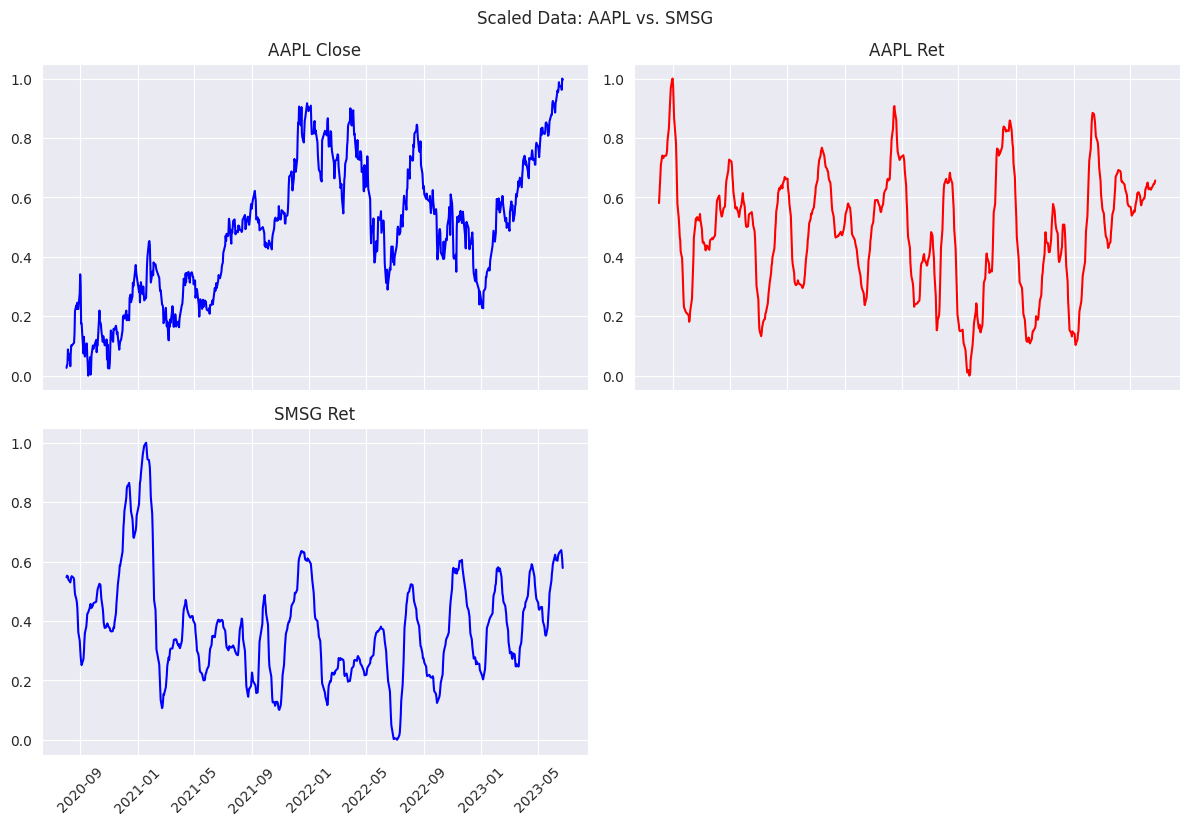

In [ ]:
# Get the column names except for the index column
columns = AAPL_SMSG_scaled.columns

# Set the number of rows and columns for subplots
num_rows = (len(columns) - 1) // 2 + 1
num_cols = 2

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle('Scaled Data: AAPL vs. SMSG')

# Flatten the axs array if there is only one row or one column
if num_rows == 1 or num_cols == 1:
    axs = [axs]

# Iterate over columns and plot each one
for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    if row < num_rows - 1:
        axs[row][col].set_xticklabels([])
    if col % 2 == 0:
      axs[row][col].plot(AAPL_SMSG_scaled.index, AAPL_SMSG_scaled[column], color='blue')
    else:
      axs[row][col].plot(AAPL_SMSG_scaled.index, AAPL_SMSG_scaled[column], color='red')
    axs[row][col].set_title(column)

# Remove any unused subplots
if len(columns) < num_rows * num_cols:
    for j in range(len(columns), num_rows * num_cols):
        row = j // num_cols
        col = j % num_cols
        fig.delaxes(axs[row][col])

fig.tight_layout()

# Rotate x-axis labels for better visibility
for ax_row in axs:
    for ax in ax_row:
        ax.tick_params(axis='x', rotation=45)

# Display the plot
plt.show()

In [ ]:
def create_dataset(dataset, lookback, column):
    X_train = []
    Y_train = []

    for i in range(lookback, len(dataset)):
        X_train.append(dataset.iloc[i-lookback:i, dataset.columns != 'Data'].values)
        Y_train.append(dataset[column].iloc[i])

    return np.array(X_train), np.array(Y_train)

In [ ]:
# Split the data into training, validation, and testing sets
AAPL_SMSG_train_size = int(len(AAPL_SMSG_scaled) * 0.7)
AAPL_SMSG_val_size   = int(len(AAPL_SMSG) * 0.2)
AAPL_SMSG_train_data = AAPL_SMSG_scaled[:AAPL_SMSG_train_size]
AAPL_SMSG_val_data   = AAPL_SMSG_scaled[AAPL_SMSG_train_size:AAPL_SMSG_train_size + AAPL_SMSG_val_size]
AAPL_SMSG_test_data  = AAPL_SMSG_scaled[AAPL_SMSG_train_size + AAPL_SMSG_val_size:]

AMZN_BABA_train_size = int(len(AMZN_BABA_scaled) * 0.7)
AMZN_BABA_val_size   = int(len(AMZN_BABA_scaled) * 0.2)
AMZN_BABA_train_data = AMZN_BABA_scaled[:AMZN_BABA_train_size]
AMZN_BABA_val_data   = AMZN_BABA_scaled[AMZN_BABA_train_size:AMZN_BABA_train_size + AMZN_BABA_val_size]
AMZN_BABA_test_data  = AMZN_BABA_scaled[AMZN_BABA_train_size + AMZN_BABA_val_size:]

In [ ]:
AAPL_SMSG_X_train, AAPL_SMSG_Y_train = create_dataset(AAPL_SMSG_train_data, lookback=7, column='AAPL Ret')
AMZN_BABA_X_train, AMZN_BABA_Y_train = create_dataset(AMZN_BABA_train_data, lookback=7, column='AMZN Ret')

AAPL_SMSG_X_val, AAPL_SMSG_Y_val = create_dataset(AAPL_SMSG_val_data, lookback=7, column='AAPL Ret')
AMZN_BABA_X_val, AMZN_BABA_Y_val = create_dataset(AMZN_BABA_val_data, lookback=7, column='AMZN Ret')

AAPL_SMSG_X_test, AAPL_SMSG_Y_test = create_dataset(AAPL_SMSG_test_data, lookback=7, column='AAPL Ret')
AMZN_BABA_X_test, AMZN_BABA_Y_test = create_dataset(AMZN_BABA_test_data, lookback=7, column='AMZN Ret')

## **Training and evaluating the model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
def smape(actual, predicted):
    numerator = tf.abs(actual - predicted)
    denominator = (tf.abs(actual) + tf.abs(predicted)) / 2.0

    smape_score = tf.reduce_mean(numerator / denominator) * 100.0

    return smape_score


def compile_and_fit(model,
                    X_train, Y_train,
                    X_val, Y_val,
                    file='',
                    _patience=10, _min_delta=0.0001, _epochs=100, _batch_size=32, _early_stopping=False, _learning_rate=0.01, _verbose=1):

  if _early_stopping:
    early_stopping = EarlyStopping(monitor='val_smape',
                                   patience=_patience,
                                   min_delta=_min_delta,
                                   mode='min')

  _optimizer = Adam(learning_rate=_learning_rate)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=_optimizer,
                metrics=[smape])

  if _verbose != 0:
    model.summary()
    plot_model(model, to_file=file, show_shapes=True, show_layer_names=True)

  if _early_stopping:
    history = model.fit(X_train, Y_train,
                        batch_size=_batch_size,
                        epochs=_epochs,
                        validation_data=(X_val, Y_val),
                        callbacks=[early_stopping],
                        verbose=_verbose)
  else:
    history = model.fit(X_train, Y_train,
                        batch_size=_batch_size,
                        epochs=_epochs,
                        validation_data=(X_val, Y_val),
                        verbose=_verbose)
  return history

In [ ]:
lookback = 7
features = 3

#################### AAPL ####################
AAPL_regressor = Sequential()

AAPL_regressor.add(SimpleRNN(units=8,
                   input_shape=(lookback, features)))

AAPL_regressor.add(Dense(units=1))
##############################################

#################### AMZN ####################
AMZN_regressor = Sequential()

AMZN_regressor.add(SimpleRNN(units=8,
                   input_shape=(lookback, features)))

AMZN_regressor.add(Dense(units=1))
##############################################

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 96        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 6s 58ms/step - loss: 0.1056 - smape: 56.7295 - val_loss: 0.0202 - val_smape: 26.9430
Epoch 2/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0293 - smape: 34.3135 - val_loss: 0.0259 - val_smape: 34.9908
Epoch 3/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0168 - smape: 26.1115 - val_loss: 0.0094 - val_smape: 19.6053
Epoch 4/100
15/15 [=====================

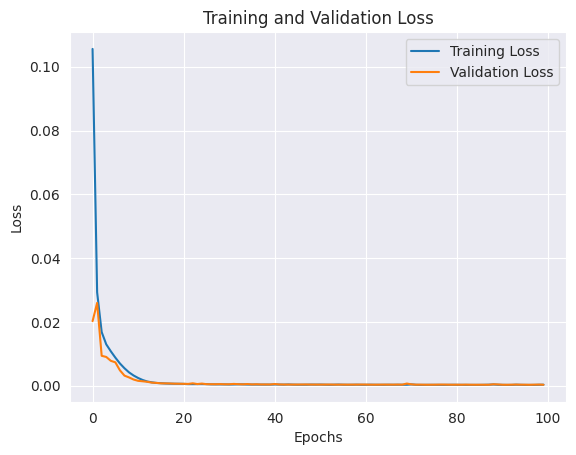

In [ ]:
history = compile_and_fit(AAPL_regressor, X_train=AAPL_SMSG_X_train, Y_train=AAPL_SMSG_Y_train, X_val=AAPL_SMSG_X_val, Y_val=AAPL_SMSG_Y_val, _batch_size=32)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AAPL_predictions = AAPL_regressor.predict(AAPL_SMSG_X_test)

# Evaluate the model on the test dataset
loss = AAPL_regressor.evaluate(AAPL_SMSG_X_test, AAPL_SMSG_Y_test, batch_size=32)

2/2 [==============================] - 0s 10ms/step - loss: 9.4431e-05 - smape: 1.3412


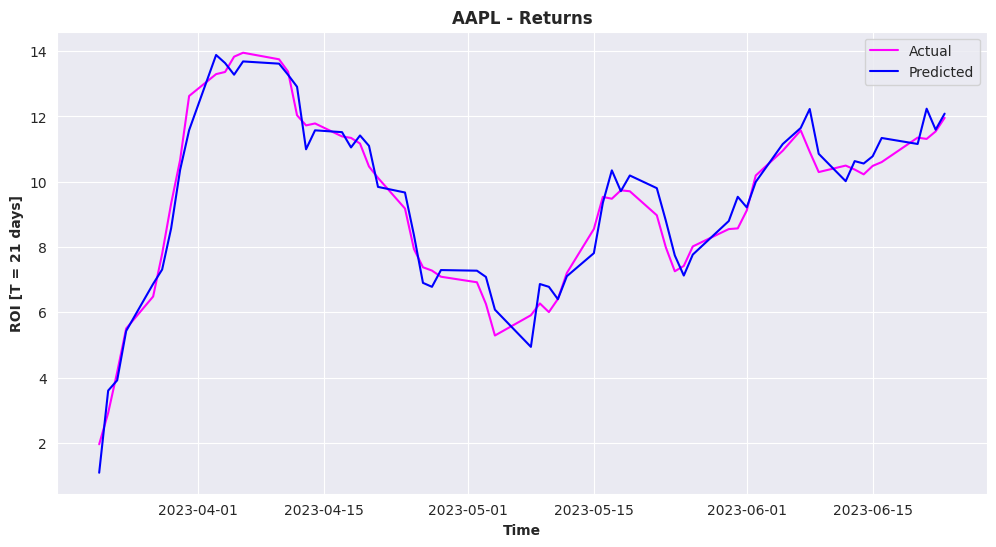

In [ ]:
# Plotting AAPL close price predictions
plt.figure(figsize=(12, 6))
plt.plot(AAPL_SMSG.index[-len(AAPL_SMSG_Y_test):].values, AAPL_Return_scaler.inverse_transform(AAPL_SMSG_Y_test.reshape(-1, 1)), label='Actual', color='magenta')
plt.plot(AAPL_SMSG.index[-len(AAPL_SMSG_Y_test):].values, AAPL_Return_scaler.inverse_transform(AAPL_predictions.reshape(-1, 1)), label='Predicted', color='blue')
plt.title('AAPL - Returns', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('ROI [T = ' + str(T) + ' days]', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 2s 24ms/step - loss: 0.1169 - smape: 49.9837 - val_loss: 0.0314 - val_smape: 24.7430
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0307 - smape: 26.5863 - val_loss: 0.0535 - val_smape: 34.1738
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0172 - smape: 22.0626 - val_loss: 0.0249 - val_smape: 23.8084
Epoch 4/100
16/16 [====================

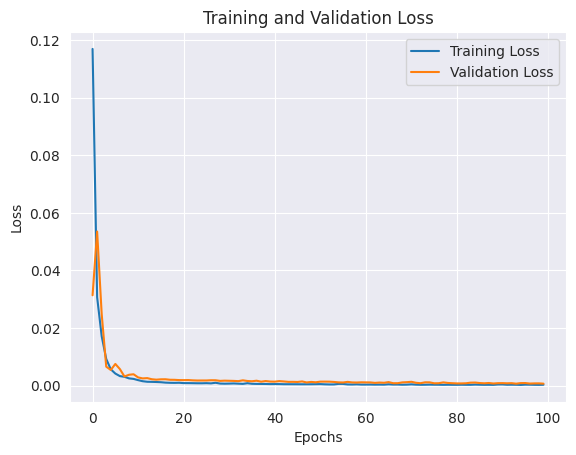

In [ ]:
history = compile_and_fit(AMZN_regressor, X_train=AMZN_BABA_X_train, Y_train=AMZN_BABA_Y_train, X_val=AMZN_BABA_X_val, Y_val=AMZN_BABA_Y_val, _batch_size=32)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AMZN_predictions = AMZN_regressor.predict(AMZN_BABA_X_test)

# Evaluate the model on the test dataset
loss = AMZN_regressor.evaluate(AMZN_BABA_X_test, AMZN_BABA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 3.8559e-04 - smape: 2.5296


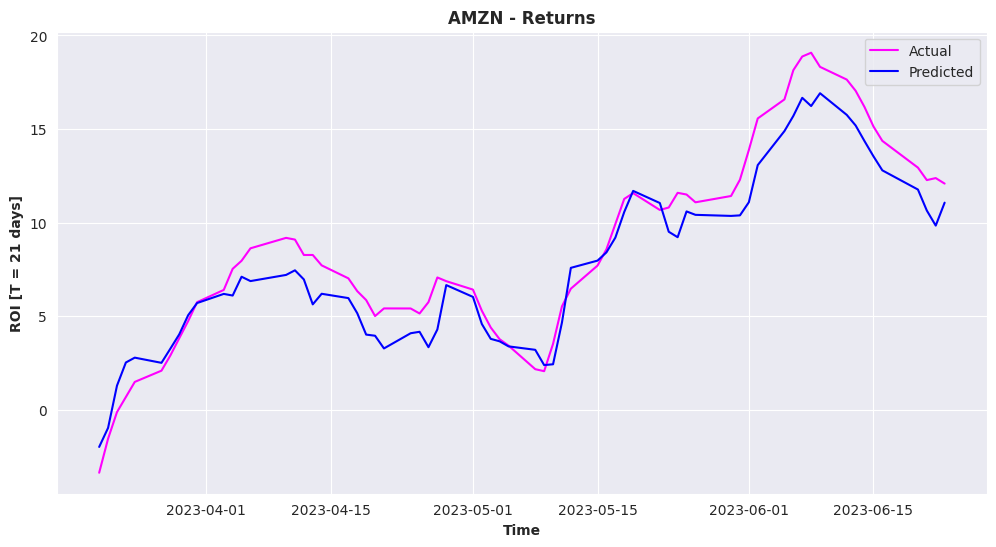

In [ ]:
# Plotting AAPL close price predictions
plt.figure(figsize=(12, 6))
plt.plot(AMZN_BABA.index[-len(AMZN_BABA_Y_test):].values, AMZN_Return_scaler.inverse_transform(AMZN_BABA_Y_test.reshape(-1, 1)), label='Actual', color='magenta')
plt.plot(AMZN_BABA.index[-len(AMZN_BABA_Y_test):].values, AMZN_Return_scaler.inverse_transform(AMZN_predictions.reshape(-1, 1)), label='Predicted', color='blue')
plt.title('AMZN - Returns', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('ROI [T = ' + str(T) + ' days]', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

# **Hyperparameter Tuning**

In [ ]:
from sklearn.metrics import mean_squared_error

def grid_search(ticker, X_train, Y_train, X_val, Y_val, _early_stopping=True, lookback=7, features=3):
  # Hyperparameter grid
  param_grid = {
      'units': [4, 8, 16, 32],
      'batch_size': [8, 16, 32],
      'epochs': [100, 250],
      'patience': [10, 25],
      'learning_rate': [0.01, 0.001]
  }

  # Initialize variables for best hyperparameters and best performance
  best_score = float('inf')
  best_params = {}

  # Iterate through the hyperparameter grid
  for _units in param_grid['units']:
      for _batch_size in param_grid['batch_size']:
          for _epochs in param_grid['epochs']:
              for _patience in param_grid['patience']:
                  for l_rate in param_grid['learning_rate']:

                      # Build the RNN model
                      regressor = Sequential()
                      regressor.add(SimpleRNN(units=_units,
                                              batch_input_shape=(_batch_size, lookback, features)))
                      regressor.add(Dense(units=1))

                      # Compile and fit the model
                      history = compile_and_fit(model=regressor,
                                                X_train = X_train,
                                                Y_train = Y_train,
                                                X_val   = X_val,
                                                Y_val   = Y_val,
                                                _early_stopping = _early_stopping,
                                                _patience       = _patience,
                                                _min_delta      = 1e-5,
                                                _epochs         = _epochs,
                                                _batch_size     = _batch_size,
                                                _learning_rate  = l_rate,
                                                _verbose        = 0)

                      # Get MSE of the validation set
                      mse = history.history['val_loss']

                      # Check if current model's performance is better than the best so far
                      if mse < best_score:
                          best_score = mse
                          best_params = {'units': _units, 'batch_size': _batch_size, 'epochs': _epochs, 'patience': _patience, 'learning_rate': l_rate}
                          print("NEW Best", best_params)
                          print('\t\tMSE: ', mse)

  # Print the best hyperparameters and best MSE score
  print(str(ticker) + " - Best Hyperparameters:", best_params)
  print(str(ticker) + " - Best MSE Score:", best_score)

In [ ]:
grid_search(ticker='AAPL',
            X_train = AAPL_SMSG_X_train,
            Y_train = AAPL_SMSG_Y_train,
            X_val   = AAPL_SMSG_X_val,
            Y_val   = AAPL_SMSG_Y_val,
            _early_stopping=True)

2/2 [==============================] - 0s 7ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 100, 'patience': 10, 'learning_rate': 0.1}
		MSE:  0.014691850136176089
2/2 [==============================] - 0s 18ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 100, 'patience': 10, 'learning_rate': 0.01}
		MSE:  0.00012671130775009402


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 100, 'patience': 25, 'learning_rate': 0.001}
		MSE:  0.00010133959800037136
2/2 [==============================] - 0s 5ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 250, 'patience': 10, 'learning_rate': 0.001}
		MSE:  8.907148935184663e-05
2/2 [==============================] - 0s 8ms/step
NEW Best {'units': 4, 'batch_size': 4, 'epochs': 250, 'patience': 25, 'learning_rate': 0.001}
		MSE:  8.767789197902349e-05
2/2 [==============================] - 0s 8ms/step
NEW Best {'units': 8, 'batch_size': 1, 'epochs': 100, 'patience': 25, 'learning_rate': 0.001}
		MSE:  8.27682303409719e-05
2/2 [==============================] - 0s 10ms/step


In [ ]:
grid_search(ticker='AMZN',
            X_train = AMZN_BABA_X_train,
            Y_train = AMZN_BABA_Y_train,
            X_val   = AMZN_BABA_X_val,
            Y_val   = AMZN_BABA_Y_val,
            _early_stopping=True)

3/3 [==============================] - 0s 5ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 100, 'patience': 10, 'learning_rate': 0.1}
		MSE:  0.03567126561216291
3/3 [==============================] - 0s 5ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 100, 'patience': 10, 'learning_rate': 0.01}
		MSE:  0.0003208239895050927


3/3 [==============================] - 0s 4ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 100, 'patience': 10, 'learning_rate': 0.001}
		MSE:  8.458618989604407e-05


3/3 [==============================] - 0s 4ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 250, 'patience': 10, 'learning_rate': 0.01}
		MSE:  7.826153245675328e-05
3/3 [==============================] - 0s 6ms/step
NEW Best {'units': 4, 'batch_size': 1, 'epochs': 250, 'patience': 25, 'learning_rate': 0.001}
		MSE:  7.300760867495163e-05
3/3 [==============================] - 0s 5ms/step
NEW Best {'units': 4, 'batch_size': 2, 'epochs': 100, 'patience': 25, 'learning_rate': 0.01}
		MSE:  6.852944437173753e-05
3/3 [==============================] - 0s 4ms/step
NEW Best {'units': 4, 'batch_size': 2, 'epochs': 250, 'patience': 25, 'learning_rate': 0.001}
		MSE:  6.661410856158005e-05
3/3 [==============================] - 0s 6ms/step
NEW Best {'units': 4, 'batch_size': 4, 'epochs': 100, 'patience': 10, 'learning_rate': 0.001}
		MSE:  6.582266612961697e-05
3/3 [==============================] - 0s 6ms/step
